In [ ]:
import anndata as ad
import pandas as pd
import numpy as np
import scipy.sparse 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from ploidex.allele_utils import AlleleRatioCalculator, calculate_allelic_ratios
from ploidex.multimapping import MultimappingRatioCalculator, calculate_multi_ratios
from ploidex.filter import filter_low_expression
from ploidex.plotting import plot_allelic_ratios, plot_allelic_ratios_comparison, plot_top_differential_syntelogsplot_top_differential_syntelogs
from ploidex.ase_data_loader import load_ase_data
from ploidex.stats import test_allelic_ratios_between_conditions
from scipy.stats import binom, norm, chi2, betabinom, nbinom  # pylint: disable-msg=E0611
from scipy.special import gammaln, polygamma  # pylint: disable-msg=E0611
from scipy.optimize import minimize, minimize_scalar
#from isotools._transcriptome_stats import betabinom_lr_test, betabinom_ll, betabinom_ml
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import re
import igv_notebook

# Read in the allele specific count data and some metadata about the alleles

In [3]:
# Define your file paths
var_obs_file = "/scratch/nadjafn/potato-allelic-orthogroups/output_atlantic/07_SYNTELOG_SIMILARITY/ATL_v3.hc_gene_models.repr_blast_syntelog_blast_analysis.tsv"
gene_counts_dir = "/scratch/nadjafn/Atlantic_ASE/polyploid-allele-exp/results/03_GENECOUNTS"

# Define sample IDs and their conditions
sample_info = {
    "SRR14993892": "leaf",
    "SRR14993893": "leaf", 
    "SRR14993894": "leaf",
    "SRR14993895": "leaf",
    "SRR14996168": "leaf",
    "SRR14995031": "tuber",
    "SRR14995032": "tuber",
    "SRR14995033": "tuber",
    "SRR14995034": "tuber",
    "SRR14995933": "tuber",
}

# Load the data without specifying counts_file
my_ad = load_ase_data(
    var_obs_file=var_obs_file,
    gene_counts_dir=gene_counts_dir,
    sample_info=sample_info
)

## Make a MDS plot to vizualize the samples

In [4]:
# Create PCA components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(my_ad.layers["unique_counts"].T)
principalDf = pd.DataFrame(
    data=principalComponents,
    columns=['principal component 1', 'principal component 2'],
    index=my_ad.var_names  # Add this line to set the correct index
)

# Add condition directly from var
principalDf['condition'] = my_ad.var["condition"]
finalDf = principalDf

In [5]:
# split into haplotypes 
# Create PCA components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(my_ad.layers["unique_counts"].T)
principalDf = pd.DataFrame(
    data=principalComponents,
    columns=['principal component 1', 'principal component 2'],
    index=my_ad.var_names  # Add this line to set the correct index
)

# Add condition directly from var
principalDf['condition'] = my_ad.var["condition"]
finalDf = principalDf

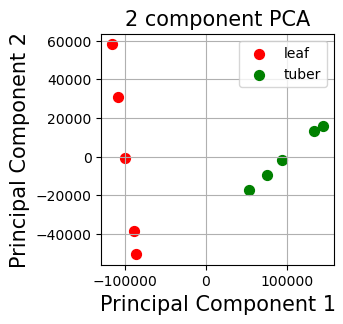

In [6]:
fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 15)

targets = ['leaf', 'tuber']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['condition'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Create an example anndata object for the long read data

In [7]:
# make a test adata which contains the entries for the first 10 Synt_ids
mask = np.isin(my_ad.obsm["Synt_id"], my_ad.obsm["Synt_id"][:1000])

# Apply the mask to subset the AnnData object
test_ad = my_ad[mask].copy()

In [8]:
test_ad = my_ad

## Filter genenes by expression

We filter Syntelog groups that don't have a min expression. This function can also be used to filter for gene_id expression or similar

In [9]:
test_ad = filter_low_expression(test_ad, min_expression=50, group_col= 'Synt_id', mode= 'all')


Filtered out 25386 groups
Kept 2949 / 97433 items


## Calculate allelic ratios

In [10]:
test_ad = calculate_allelic_ratios(test_ad, 'unique_counts')
#test_ad = calculate_allelic_ratios(test_ad, 'salmon_counts')
test_ad = calculate_multi_ratios(test_ad, 'unique_counts', 'ambiguous_counts')

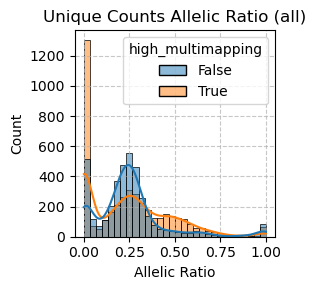

In [11]:
plot_allelic_ratios(
    test_ad,
    synteny_category="1hap1_1hap2_1hap3_1hap4_s", 
    sample='all', 
    ratio_type="unique",
    figsize = (3,3),
    kde = True,
    multimapping_threshold=0.1
)

We observe that some genes have high bias towards one allele ('allelic_ratio_unique_counts' > 0.8). We can inspect these genes to see if there are any mistakes. In the next plot we will only look at genes that have the same CDS length for all allels

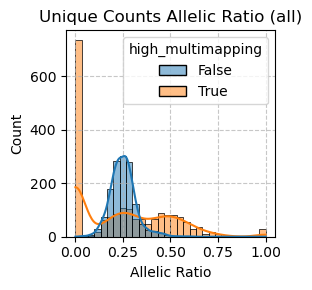

In [12]:
# filter transcripts that are not equal lengths
mask = test_ad.obsm["CDS_haplotype_with_longest_annotation"] == "equal_lengths"
test_ad_length_filter = test_ad[mask].copy()
plot_allelic_ratios(
    test_ad_length_filter,
    synteny_category="1hap1_1hap2_1hap3_1hap4_s", 
    sample='all', 
    ratio_type="unique",
    figsize = (3,3),
    kde = True,
    multimapping_threshold=0.1
)

And genes with high bias should be gone. If there are still genes that have high allelic ratios and now mulitmapping reads we can extract them and analyze them in Jbrowse or similar 

In [13]:
high_bias = test_ad[(test_ad.layers['multimapping_ratio'] < 0.25)[:, 0] & (test_ad.layers['allelic_ratio_unique_counts'] > 0.8)[:, 0] & (test_ad.obsm["synteny_category"] == "1hap1_1hap2_1hap3_1hap4_s")]# & (test_ad.obsm["CDS_haplotype_with_longest_annotation"] == "equal_lengths") ]

In [14]:
high_bias

View of AnnData object with n_obs × n_vars = 15 × 10
    var: 'condition'
    obsm: 'transcript_id', 'Synt_id', 'synteny_category', 'CDS_haplotype_with_longest_annotation', 'CDS_length_category', 'mismatch_category', 'mismatch', 'SRR14993892', 'SRR14993893', 'SRR14993894', 'SRR14993895', 'SRR14996168', 'SRR14995031', 'SRR14995032', 'SRR14995033', 'SRR14995034', 'SRR14995933'
    layers: 'unique_counts', 'ambiguous_counts', 'allelic_ratio_unique_counts', 'multimapping_ratio'

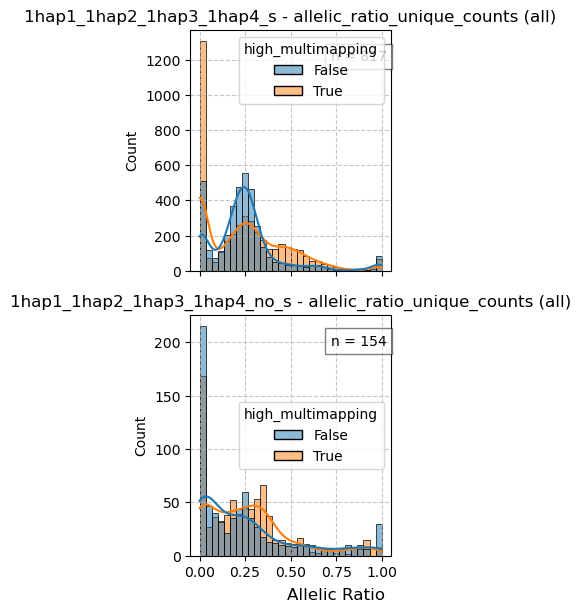

In [15]:
plot_allelic_ratios_comparison(
    test_ad,
    synteny_categories=["1hap1_1hap2_1hap3_1hap4_s", "1hap1_1hap2_1hap3_1hap4_no_s"],
    ratio_layer="allelic_ratio_unique_counts",
    multimapping_threshold=0.1,
    bins=30,
    figsize=(3, 6)
)

# Testing for Allelic imbalance

In [16]:
mask = (test_ad.obsm["CDS_haplotype_with_longest_annotation"] == "equal_lengths") & (test_ad.obsm["synteny_category"] == "1hap1_1hap2_1hap3_1hap4_s")
test_ad_length_filter = test_ad[mask].copy()

In [17]:
test_ad_length_filter

AnnData object with n_obs × n_vars = 336 × 10
    var: 'condition'
    obsm: 'transcript_id', 'Synt_id', 'synteny_category', 'CDS_haplotype_with_longest_annotation', 'CDS_length_category', 'mismatch_category', 'mismatch', 'SRR14993892', 'SRR14993893', 'SRR14993894', 'SRR14993895', 'SRR14996168', 'SRR14995031', 'SRR14995032', 'SRR14995033', 'SRR14995034', 'SRR14995933'
    layers: 'unique_counts', 'ambiguous_counts', 'allelic_ratio_unique_counts', 'multimapping_ratio'

In [ ]:
def test_allelic_ratios_between_conditions(adata, layer="unique_counts", group_key="condition", inplace=True):
    """
    Test if allelic ratios change between conditions and store results in AnnData object.
    
    Parameters
    -----------
    adata : AnnData
        AnnData object containing expression data
    layer : str, optional
        Layer containing count data (default: "unique_counts")
    group_key : str, optional
        Variable column name containing condition information (default: "condition")
    inplace : bool, optional
        Whether to modify the input AnnData object or return a copy (default: True)
        
    Returns
    --------
    AnnData or None
        If inplace=False, returns modified copy of AnnData; otherwise returns None
        Results are stored in:
        - adata.uns['allelic_ratio_test']: Complete test results as DataFrame
        - adata.obsm['allelic_ratio_pval']: P-values for each allele
        - adata.obsm['allelic_ratio_FDR']: FDR-corrected p-values for each allele
    pd.DataFrame
        Results of statistical tests for each syntelog
    """
    import pandas as pd
    import numpy as np
    import re
    from statsmodels.stats.multitest import multipletests
    
    # Work on a copy if not inplace
    if not inplace:
        adata = adata.copy()
        
    # Get counts and metadata
    counts = adata.layers[layer].copy()  # Create a copy to avoid modifying original
    
    # Ensure allelic ratio layer exists
    if "allelic_ratio_unique_counts" not in adata.layers:
        raise ValueError("Layer 'allelic_ratio_unique_counts' not found in AnnData object")
    allelic_ratio_counts = adata.layers["allelic_ratio_unique_counts"].copy()
    
    # Check for syntelog IDs
    if "Synt_id" not in adata.obsm:
        raise ValueError("'Synt_id' not found in adata.obsm")
    synt_ids = adata.obsm["Synt_id"]
    
    # Check for transcript IDs
    if "transcript_id" not in adata.obsm:
        raise ValueError("'transcript_id' not found in adata.obsm")
    transcript_ids = adata.obsm["transcript_id"]
    
    # Check conditions
    if group_key not in adata.var:
        raise ValueError(f"Group key '{group_key}' not found in adata.var")
    conditions = adata.var[group_key].values
    
    # Get unique conditions and syntelog IDs
    unique_conditions = np.unique(conditions)
    if len(unique_conditions) != 2:
        raise ValueError(f"Need exactly 2 conditions, found {len(unique_conditions)}: {unique_conditions}")
    
    unique_synt_ids = np.unique(synt_ids)
    
    # Prepare results dataframe
    results = []
    
    # Create empty arrays for storing p-values in adata.obsm
    pvals = np.full(adata.n_obs, np.nan)
    fdr_pvals = np.full(adata.n_obs, np.nan)
    ratio_diff = np.full(adata.n_obs, np.nan)
    
    # Create empty arrays for mean ratios per condition
    mean_ratio_cond1 = np.full(adata.n_obs, np.nan)
    mean_ratio_cond2 = np.full(adata.n_obs, np.nan)
    
    # Track progress
    total_syntelogs = len(unique_synt_ids)
    processed = 0
    
    # Process each syntelog
    for synt_id in unique_synt_ids:
        processed += 1
        if processed % 100 == 0:
            print(f"Processing syntelog {processed}/{total_syntelogs}")
            
        # Find alleles (observations) belonging to this syntelog
        allele_indices = np.where(synt_ids == synt_id)[0]

        # Skip if fewer than 2 alleles found (need at least 2 for ratio testing)
        if len(allele_indices) < 2:
            continue
            
        for allele_idx, allele_pos in enumerate(allele_indices):
            allele_counts = []
            condition_total = []
            allelic_ratios = {}
            
            for condition_idx, condition in enumerate(unique_conditions):
                # Get samples for this condition
                condition_indices = np.where(conditions == condition)[0]
                
                # Extract counts for these alleles and samples
                condition_counts = counts[np.ix_(allele_indices, condition_indices)]

                # Sum across samples to get total counts per allele for this condition
                total_counts = np.sum(condition_counts, axis=0)
                
                # Get allelic ratios for this condition
                condition_ratios = allelic_ratio_counts[np.ix_(allele_indices, condition_indices)]
        
                # Append arrays for total counts
                condition_total.append(total_counts)

                # Append array for this specific allele's counts
                allele_counts.append(condition_counts[allele_idx])
                #print(condition_ratios[allele_idx])
                # Store ratios for this condition
                allelic_ratios[condition] = condition_ratios[allele_idx]
            
            # Run the beta-binomial likelihood ratio test
            try:
                test_result = betabinom_lr_test(allele_counts, condition_total)
                p_value, ratio_stats = test_result[0], test_result[1]
                
                # Calculate absolute difference in mean ratios between conditions
                ratio_difference = abs(ratio_stats[0] - ratio_stats[2])
            except Exception as e:
                print(f"Error testing syntelog {synt_id}, allele {allele_idx}: {str(e)}")
                continue
            
            # Get transcript ID and parse allele info
            transcript_id = transcript_ids[allele_pos]
            
            # Extract allele number from transcript ID
            try:
                allele_match = re.search(r'\dG', transcript_id)
                if allele_match:
                    allele_num = allele_match.group(0).split('G')[0]
                else:
                    allele_num = f"{allele_idx+1}"  # Fallback if regex fails
            except:
                allele_num = f"{allele_idx+1}"  # Fallback if regex fails
            
            # Store p-value in the arrays we created
            pvals[allele_pos] = p_value
            ratio_diff[allele_pos] = ratio_difference
            mean_ratio_cond1[allele_pos] = ratio_stats[0]
            mean_ratio_cond2[allele_pos] = ratio_stats[2]
            
            # Store results for each replicate
            for replicate in range(len(allelic_ratios[unique_conditions[0]])):
                results.append({
                    'Synt_id': synt_id,
                    'allele': allele_num,
                    'transcript_id': transcript_id,
                    'p_value': p_value,
                    'ratio_difference': ratio_difference,
                    'n_alleles': len(allele_indices),
                    'replicate': replicate,
                    f'ratios_{unique_conditions[0]}_mean': ratio_stats[0],
                    f'ratios_rep_{unique_conditions[0]}': allelic_ratios[unique_conditions[0]][replicate],
                    f'ratios_{unique_conditions[1]}_mean': ratio_stats[2],
                    f'ratios_rep_{unique_conditions[1]}': allelic_ratios[unique_conditions[1]][replicate]
                })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Multiple testing correction if we have results
    if len(results_df) > 0:
        results_df['FDR'] = multipletests(results_df['p_value'], method='fdr_bh')[1]
        results_df = results_df.sort_values('p_value')
        
        # Map FDR values back to the individual alleles
        # Group by transcript_id and take the first FDR value (they should be the same for all replicates)
        fdr_map = results_df.groupby('transcript_id')['FDR'].first().to_dict()
        
        # Update the FDR array
        for i, transcript_id in enumerate(transcript_ids):
            if transcript_id in fdr_map:
                fdr_pvals[i] = fdr_map[transcript_id]
    
    # Store results in the AnnData object
    adata.uns['allelic_ratio_test'] = results_df
    adata.obsm['allelic_ratio_pval'] = pvals
    adata.obsm['allelic_ratio_FDR'] = fdr_pvals
    adata.obsm['allelic_ratio_difference'] = ratio_diff
    adata.obsm[f'allelic_ratio_mean_{unique_conditions[0]}'] = mean_ratio_cond1
    adata.obsm[f'allelic_ratio_mean_{unique_conditions[1]}'] = mean_ratio_cond2
    
    # Print summary
    significant_results = results_df[(results_df['FDR'] < 0.05)]
    print(f"Found {len(significant_results)/4} from {len(results_df)/4} syntelogs with significantly different allelic ratios (FDR < 0.05)")
    
    # Return AnnData object if not inplace
    if not inplace:
        return adata
    else:
        return results_df

# Example usage:
results_df = test_allelic_ratios(test_ad_length_filter)
# Now test_ad_length_filter will have allelic ratio test results stored in its attributes

Found 130.0 from 420.0 syntelogs with significantly different allelic ratios (FDR < 0.05)


In [32]:
results_df

,Synt_id,allele,transcript_id,p_value,ratio_difference,n_alleles,replicate,ratios_leaf_mean,ratios_rep_leaf,ratios_tuber_mean,ratios_rep_tuber,FDR
889,Synt_id_25421,3,Soltu.Atl_v3.09_3G021140.2,2.047150e-08,0.174159,4,4,0.214269,0.219277,0.388428,0.371598,0.000007
888,Synt_id_25421,3,Soltu.Atl_v3.09_3G021140.2,2.047150e-08,0.174159,4,3,0.214269,0.221863,0.388428,0.418525,0.000007
886,Synt_id_25421,3,Soltu.Atl_v3.09_3G021140.2,2.047150e-08,0.174159,4,1,0.214269,0.197943,0.388428,0.404525,0.000007
887,Synt_id_25421,3,Soltu.Atl_v3.09_3G021140.2,2.047150e-08,0.174159,4,2,0.214269,0.205317,0.388428,0.354223,0.000007
885,Synt_id_25421,3,Soltu.Atl_v3.09_3G021140.2,2.047150e-08,0.174159,4,0,0.214269,0.222930,0.388428,0.400000,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...
1050,Synt_id_28877,1,Soltu.Atl_v3.11_1G012710.1,1.000000e+00,0.000000,4,0,0.000000,0.000000,0.000000,0.000000,1.000000
1051,Synt_id_28877,1,Soltu.Atl_v3.11_1G012710.1,1.000000e+00,0.000000,4,1,0.000000,0.000000,0.000000,0.000000,1.000000
1052,Synt_id_28877,1,Soltu.Atl_v3.11_1G012710.1,1.000000e+00,0.000000,4,2,0.000000,0.000000,0.000000,0.000000,1.000000
1053,Synt_id_28877,1,Soltu.Atl_v3.11_1G012710.1,1.000000e+00,0.000000,4,3,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
results_grouped = results.groupby('Synt_id').agg({
    'p_value': lambda x: list(x),  # This collects all values into a list
    'FDR': lambda x: list(x),
    'ratios_leaf_mean': lambda x: list(x),
    'ratios_tuber_mean': lambda x: list(x)
}).reset_index()

In [38]:
results_test = results_df[results_df["Synt_id"] == "Synt_id_25421"]
# get the Synt ids with the lowest p values
# Sort by p-value and take the top 5 
top_5_syntelogs = results_df.nsmallest(5, 'p_value')['Synt_id'].unique()
# Filter the results DataFrame to include only the top 5 syntelogs
top_5_results = results_df[results_df['Synt_id'].isin(top_5_syntelogs)]

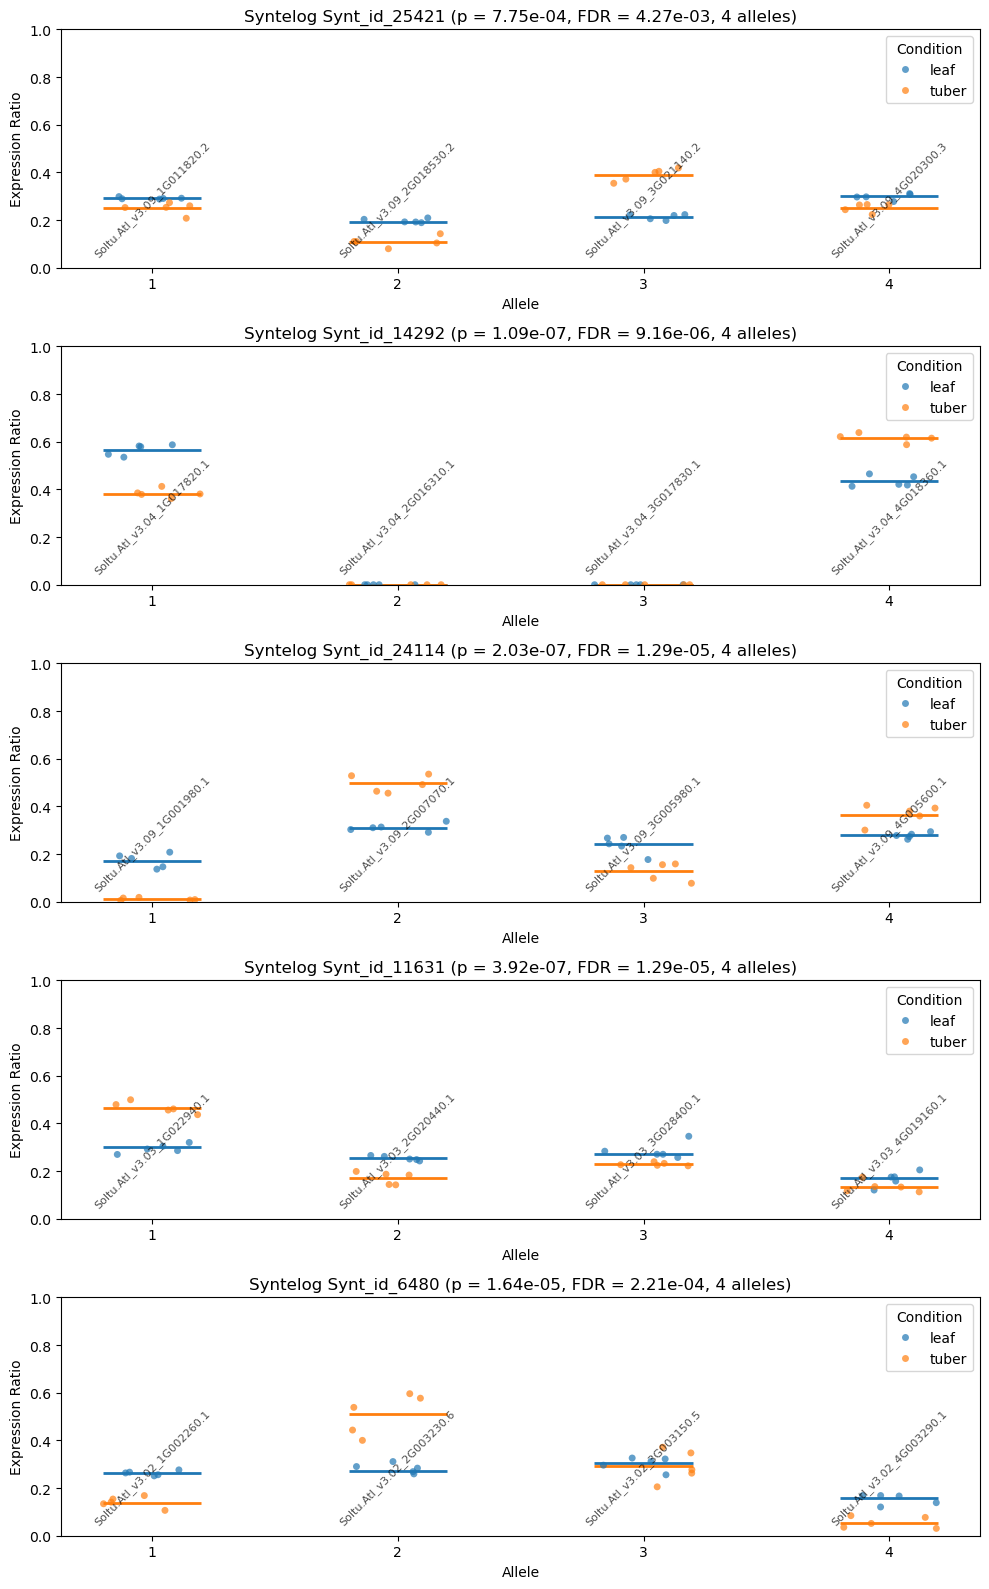

In [45]:
def plot_top_differential_syntelogs(results_df, n=5, figsize=(12, 4*5), palette=None, jitter=0.2, 
                                   alpha=0.7, ylim=(0, 1), sort_by='p_value', output_file=None):
    """
    Plot the top n syntelogs with differential allelic ratios.
    
    Parameters
    -----------
    results_df : pd.DataFrame
        Results dataframe from test_allelic_ratios function
    n : int, optional
        Number of top syntelogs to plot (default: 5)
    figsize : tuple, optional
        Figure size as (width, height) in inches (default: (12, 4*5))
    palette : dict or None, optional
        Color palette for conditions (default: None, uses seaborn defaults)
    jitter : float, optional
        Amount of jitter for strip plot (default: 0.2)
    alpha : float, optional
        Transparency of points (default: 0.7)
    ylim : tuple, optional
        Y-axis limits (default: (0, 1))
    sort_by : str, optional
        Column to sort results by ('p_value', 'FDR', or 'ratio_difference') (default: 'p_value')
    output_file : str, optional
        Path to save the figure (default: None, displays figure but doesn't save)
        
    Returns
    --------
    fig : matplotlib.figure.Figure
        The generated figure
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    
    if len(results_df) == 0:
        print("No results to plot")
        return None
    
    # Validate sort_by parameter
    if sort_by not in ['p_value', 'FDR', 'ratio_difference']:
        print(f"Invalid sort_by parameter '{sort_by}'. Using 'p_value' instead.")
        sort_by = 'p_value'
    
    # Ensure FDR column exists
    if 'FDR' not in results_df.columns and sort_by == 'FDR':
        print("FDR column not found. Using p_value for sorting.")
        sort_by = 'p_value'
    
    # Ensure ratio_difference column exists
    if 'ratio_difference' not in results_df.columns and sort_by == 'ratio_difference':
        print("ratio_difference column not found. Using p_value for sorting.")
        sort_by = 'p_value'
    
    # Get the condition names
    condition_columns = [col for col in results_df.columns if col.startswith('ratios_rep_')]
    if not condition_columns:
        print("No ratio columns found in dataframe")
        return None
    
    conditions = [col.replace('ratios_rep_', '') for col in condition_columns]
    
    # Get top n syntelogs with lowest p-values
    top_syntelogs = results_df.sort_values(sort_by).drop_duplicates('Synt_id').head(n)['Synt_id'].unique()
    
    # Filter results to include only these syntelogs
    top_results = results_df[results_df['Synt_id'].isin(top_syntelogs)]
    
    # Create the figure
    fig, axes = plt.subplots(len(top_syntelogs), 1, figsize=figsize)
    # Handle case where there's only one syntelog
    if len(top_syntelogs) == 1:
        axes = [axes]
    
    # Plot each syntelog
    for i, synt_id in enumerate(top_syntelogs):
        # Get data for this syntelog
        synt_data = top_results[top_results['Synt_id'] == synt_id].copy()
        
        # Sort by allele for better visualization
        synt_data = synt_data.sort_values('allele')
        
        # Get stats for this syntelog (take first row since they're the same for all replicates)
        p_value = synt_data['p_value'].iloc[0]
        fdr = synt_data['FDR'].iloc[0] if 'FDR' in synt_data.columns else np.nan
        n_alleles = synt_data['n_alleles'].iloc[0]
        
        # Reshape data for seaborn
        synt_data_melted = pd.melt(
            synt_data, 
            id_vars=['Synt_id', 'allele', 'transcript_id', 'replicate'], 
            value_vars=condition_columns,
            var_name='condition', 
            value_name='ratio'
        )
        
        # Clean up condition names
        synt_data_melted['condition'] = synt_data_melted['condition'].str.replace('ratios_rep_', '')
        
        # Create the stripplot
        ax = axes[i]
        sns.stripplot(
            x='allele', 
            y='ratio', 
            hue='condition', 
            data=synt_data_melted, 
            jitter=jitter, 
            alpha=alpha,
            palette=palette,
            ax=ax
        )
        
        # Add mean values as horizontal lines for each allele and condition
        for allele in synt_data['allele'].unique():
            for j, cond in enumerate(conditions):
                mean_col = f'ratios_{cond}_mean'
                if mean_col in synt_data.columns:
                    mean_val = synt_data[synt_data['allele'] == allele][mean_col].iloc[0]
                    allele_pos = list(synt_data['allele'].unique()).index(allele)
                    ax.hlines(
                        y=mean_val, 
                        xmin=allele_pos-0.2, 
                        xmax=allele_pos+0.2, 
                        colors=ax.get_legend().get_lines()[j].get_color(),
                        linewidth=2
                    )
        
        # Set title and labels
        fdr_text = f", FDR = {fdr:.2e}" if not np.isnan(fdr) else ""
        ax.set_title(f"Syntelog {synt_id} (p = {p_value:.2e}{fdr_text}, {n_alleles} alleles)")
        ax.set_xlabel('Allele')
        ax.set_ylabel('Expression Ratio')
        
        # Set y-limits
        ax.set_ylim(ylim)
        
        # Adjust legend
        ax.legend(title='Condition')
        
        # Add transcript IDs as annotations
        for j, allele in enumerate(synt_data['allele'].unique()):
            transcript = synt_data[synt_data['allele'] == allele]['transcript_id'].iloc[0]
            ax.annotate(
                f"{transcript}", 
                xy=(j, ylim[0] + 0.05), 
                ha='center', 
                fontsize=8,
                alpha=0.7,
                rotation=45
            )
    
    plt.tight_layout()
    
    # Save figure if requested
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    return fig

# Example usage:
# Get the top differential syntelogs
# top_n = 5
# fig = plot_top_differential_syntelogs(results_df, n=top_n, sort_by='FDR', output_file='top_syntelogs.png')
# plt.show()


def get_top_differential_syntelogs(results_df, n=5, sort_by='p_value', fdr_threshold=0.05):
    """
    Get the top n syntelogs with differential allelic ratios.
    
    Parameters
    -----------
    results_df : pd.DataFrame
        Results dataframe from test_allelic_ratios function
    n : int, optional
        Number of top syntelogs to return (default: 5)
    sort_by : str, optional
        Column to sort results by ('p_value', 'FDR', or 'ratio_difference') (default: 'p_value')
    fdr_threshold : float, optional
        Maximum FDR to consider a result significant (default: 0.05)
        
    Returns
    --------
    pd.DataFrame
        Filtered dataframe containing only the top n syntelogs
    """
    if len(results_df) == 0:
        print("No results to filter")
        return results_df
    
    # Validate sort_by parameter
    if sort_by not in ['p_value', 'FDR', 'ratio_difference']:
        print(f"Invalid sort_by parameter '{sort_by}'. Using 'p_value' instead.")
        sort_by = 'p_value'
    
    if sort_by == 'ratio_difference':
        sort_bool = False
    else:
        sort_bool = True
    
    # Apply FDR filter if column exists
    if 'FDR' in results_df.columns:
        sig_results = results_df[results_df['FDR'] <= fdr_threshold]
        if len(sig_results) == 0:
            print(f"No results with FDR <= {fdr_threshold}. Using all results.")
            sig_results = results_df
    else:
        sig_results = results_df
    
    # Get top n syntelogs
    top_syntelogs = sig_results.sort_values(sort_by, ascending=sort_bool).drop_duplicates('Synt_id').head(n)['Synt_id'].unique()
    
    # Return filtered dataframe
    return results_df[results_df['Synt_id'].isin(top_syntelogs)]


# Example of complete workflow:
# 1. Run allelic ratio test
# results_df = test_allelic_ratios(test_ad_length_filter)
# 
# 2. Get top differential syntelogs
top_results = get_top_differential_syntelogs(results_df, n=5, sort_by='ratio_difference', fdr_threshold=0.05, )
# 
# 3. Plot the results
fig = plot_top_differential_syntelogs(top_results, figsize=(10, 16))
plt.show()

In [ ]:
significant_results["ratios_condition1"][1]

KeyError: 'ratios_condition1'

In [ ]:
def betabinom_ml(xi, ni):
    '''Calculate maximum likelihood parameter of beta binomial distribution for a group of samples with xi successes and ni trials.

    :param xi: number of successes, here coverage of the alternative for all samples of the group as 1d numpy array
    :param ni: number of trials, here total coverage for the two sample groups for all samples of the group as 1d numpy array
    '''
    # x and n must be np arrays
    if sum(ni) == 0:
        params = params_alt = None, None
        return params, params_alt, False
    xi, ni = xi[ni > 0], ni[ni > 0]  # avoid div by 0
    prob = xi / ni
    m = prob.mean()  # estimate initial parameters
    d = prob.var()
    success = True
    if d == 0:  # just one sample? or all exactly the same proportion
        params = params_alt = m, None  # in this case the betabinomial reduces to the binomial
    else:
        d = max(d, 1e-6)  # to avoid division by 0
        e = (m**2 - m + d)  # helper
        # find ml estimates for a and b
        mle = minimize(loglike_betabinom, x0=[-m * e / d, ((m - 1) * e) / d], bounds=((1e-6, None), (1e-6, None)),
                       args=(xi, ni), options={'maxiter': 250}, method='L-BFGS-B', jac=True)
        a, b = params = mle.x
        params_alt = (a / (a + b), a * b / ((a + b)**2 * (a + b + 1)))  # get alternative parametrization (mu and disp)
        # mle = minimize(loglike_betabinom2, x0=[-d/(m*e),d/((m-1)*e)],bounds=((1e-9,None),(1e-9,None)),
        #   args=(xi,ni),options={'maxiter': 250}, method='L-BFGS-B', tol=1e-6)
        # params=([1/p for p in mle.x])
        params_alt = (a / (a + b), a * b / ((a + b)**2 * (a + b + 1)))  # get alternative parametrization (mu and disp)

        if not mle.success:
            # should not happen to often, mainly with mu close to boundaries
            logger.debug(f'no convergence in betabinomial fit: k={xi}\nn={ni}\nparams={params}\nmessage={mle.message}')
            success = False  # prevent calculation of p-values based on non optimal parameters
    return params, params_alt, success


def betabinom_ll(x, n, a, b):
    if b is None:
        return binom.logpmf(x, n, a).sum()
    else:
        return betabinom.logpmf(x, n, a, b).sum()
    
def betabinom_lr_test(x, n):
    ''' Likelihood ratio test with random-effects betabinomial model.

    This test modles x as betabinomial(n,a,b), eg a binomial distribution, where p follows beta ditribution with parameters a,b>0
    mean m=a/(a+b) overdispersion d=ab/((a+b+1)(a+b)^2) --> a=-m(m^2-m+d)/d b=(m-1)(m^2-m+d)/d
    principle: log likelihood ratio of M0/M1 is chi2 distributed

    :param x: coverage of the alternative for the two sample groups
    :param n: total coverage for the two sample groups'''

    if any(ni.sum() == 0 for ni in n):
        return (np.nan, [None, None])  # one group is not covered at all - no test possible. Checking this to avoid RuntimeWarnings (Mean of empty slice)
    x_all, n_all = (np.concatenate(x), np.concatenate(n))
    # calculate ml parameters
    ml_1 = betabinom_ml(x[0], n[0])
    ml_2 = betabinom_ml(x[1], n[1])
    ml_all = betabinom_ml(x_all, n_all)

    if not (ml_1[2] and ml_2[2] and ml_all[2]):  # check success
        return np.nan, list(ml_1[1] + ml_2[1] + ml_all[1])
    try:
        l0 = betabinom_ll(x_all, n_all, *ml_all[0]).sum()
        l1 = betabinom_ll(x[0], n[0], *ml_1[0]).sum() + betabinom_ll(x[1], n[1], *ml_2[0]).sum()
    except (ValueError, TypeError):
        logger.critical(f'betabinom error: x={x}\nn={n}\nparams={ml_1[0]}/{ml_2[0]}/{ml_all[0]}')  # should not happen
        raise
    return chi2.sf(2 * (l1 - l0), 2), list(ml_1[1] + ml_2[1] + ml_all[1])  # note that we need two degrees of freedom here as h0 hsa two parameters, h1 has 4

def loglike_betabinom(params, k, n):
    '''returns  log likelihood of betabinomial and its partial derivatives'''
    a, b = params
    logpdf = gammaln(n + 1) + gammaln(k + a) + gammaln(n - k + b) + gammaln(a + b) - \
        (gammaln(k + 1) + gammaln(n - k + 1) + gammaln(a) + gammaln(b) + gammaln(n + a + b))
    e = polygamma(0, a + b) - polygamma(0, n + a + b)
    da = e + polygamma(0, k + a) - polygamma(0, a)
    db = e + polygamma(0, n - k + b) - polygamma(0, b)
    return -np.sum(logpdf), np.array((-np.sum(da), -np.sum(db)))



In [ ]:
# Example input data structure
x = [
    np.array([15, 20, 18, 22]),  # Alternative splice junction counts for group 1 (4 samples)
    np.array([5, 8, 4, 7])       # Alternative splice junction counts for group 2 (4 samples)
]

n = [
    np.array([50, 55, 48, 60]),  # Total read counts for group 1 (4 samples)
    np.array([45, 52, 40, 55])   # Total read counts for group 2 (4 samples)
]

In [ ]:
betabinom_lr_test(x, n)

# The betabinom_lr_test function returns a tuple with two elements:

# P-value (float or np.nan):

# The p-value from the chi-square test that indicates the statistical significance of differential splicing between the two groups
# A low p-value suggests significant differences in alternative splicing patterns between the groups
# Returns np.nan if the test cannot be performed (e.g., when there's no coverage in one group)


# Parameter list (list):

# Contains the maximum likelihood estimates of beta-binomial parameters for each group and the combined data
# Specifically returns: [m1, d1, m2, d2, m_all, d_all] where:

# m1: Estimated mean PSI (Percent Spliced In) for group 1
# d1: Estimated dispersion parameter for group 1
# m2: Estimated mean PSI for group 2
# d2: Estimated dispersion parameter for group 2
# m_all: Estimated mean PSI for both groups combined
# d_all: Estimated dispersion parameter for both groups combined


# Returns [None, None] if one group has no coverage

(np.float64(0.00016746091994375317),
 [np.float64(0.35208387695713195),
  np.float64(3.447952837749216e-05),
  np.float64(0.12496801376319147),
  np.float64(4.613040370116988e-06),
  np.float64(0.23868525349609562),
  np.float64(0.01018085094963731)])

## Visualization

In [ ]:




igv_notebook.init()

b = igv_notebook.Browser(
    {
        "reference": {
            "id": "NC_045523v3",
            "name": "potato",
            "fastaURL": "/scratch/nadjafn/reference/Atlantic/ATL_v3.fa",
            "indexURL": "/scratch/nadjafn/reference/Atlantic/ATL_v3.fa.fai",
        },
        "locus": "chr_01_1:165,799..205,800"
    })

